# Instance creator utility
## Imports

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
from pathlib import Path
from matplotlib import rcParams
from sklearn.cluster import KMeans
from dataclasses import dataclass
import sys, os

#rcParams['text.usetex'] = True

sys.path.append('..')
from res.models import Node, Edge, Network, Fleet
from res.models import ElectricVehicle as EV

## Variables setting

In [2]:
mat_path = Path('../data/mat_files/Santiago22.mat')

fig_width, fig_height = 10, 12.941
full_figratio = (fig_width, fig_height)

## Useful functions

In [3]:
def edge_data(data, i, j, t):
    soc_data = data['starting_time'][0][t]['origin'][0][i]['destination'][0][j]['soc'][0]*24/(1000*3600) # Ws
    tt_data  = data['starting_time'][0][t]['origin'][0][i]['destination'][0][j]['time'][0] # s
    soc_mean, tt_mean = np.mean(soc_data), np.mean(tt_data)
    soc_std, tt_std = np.std(soc_data), np.std(tt_data)
    return (soc_mean, tt_mean), (soc_std, tt_std)

def network_size(data):
    return len(data['starting_time'][0][0]['origin'][0])

def get_velocity_realizations(data, std_factor=1.0):
    net_size = network_size(data)
    data_points = len(data['starting_time'][0])

    v_mean_matrix = np.zeros((1, data_points))
    v_std_matrix = np.zeros((1, data_points))
    
    for i in range(net_size):
        for j in range(net_size):
            if i == j:
                continue             
            (soc_morning, tt_morning),_ = edge_data(data, i, j, 0)            
            v_avg = 40*1000/3600  # 40 km/h -> m/s
            dij = tt_morning * v_avg  # m
            if dij == .0:
                continue
            v_array_mean = np.zeros((1, data_points))
            v_array_std = np.zeros((1, data_points))
            for t in range(data_points):
                (soc_mean, tt_mean), (soc_std, tt_std) = edge_data(data, i, j, t)
                v_array_mean[0, t] = dij/tt_mean
                # v_array_std[0, t] = std_factor*tt_std*(dij/tt_std)**2/dij
                v_array_std[0, t] = std_factor * tt_std * (dij/tt_mean) ** 2 / dij
            
                
            v_mean_matrix = np.append(v_mean_matrix, v_array_mean, axis = 0)
            v_std_matrix = np.append(v_std_matrix, v_array_std, axis = 0)
            
    v_mean_matrix = v_mean_matrix[1:, :]
    v_std_matrix = v_std_matrix[1:, :]
    
    return v_mean_matrix, v_std_matrix

def plot_profiles(mean_velocity, std_velocity):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, fig_height/3))
    for row_mean, row_std in zip(mean_velocity, std_velocity):
        ax1.plot(row_mean)
        ax1.set_xlabel("Sample instant")
        ax1.set_ylabel("Velocity average [m/s]")

        ax2.plot(row_std)
        ax2.set_xlabel("Sample instant")
        ax2.set_ylabel("Velocity std [m/s]")
    return fig

def plot_profile(mean_velocity, std_velocity, i):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, fig_height/3))
    ax1.plot(mean_velocity[i, :])
    ax1.set_xlabel("Sample instant")
    ax1.set_ylabel("Velocity average [m/s]")

    ax2.plot(std_velocity[i, :])
    ax2.set_xlabel("Sample instant")
    ax2.set_ylabel("Velocity std [m/s]")
    return fig

def create_network(mean_velocity, std_velocity, n_customers, n_charg_sta, min_radius, max_radius, min_theta, max_theta, minreq, maxreq, 
                   mintime, maxtime, mintw_low, maxtw_low, mintw_width, maxtw_width, cs_capacity, std_factor, tech_list, tech_price, 
                   tech_name, cs_at_depot = False, which_technology = None, depot_loc=(0., 0)):
    # Nodes
    nodes = {}
    customer_locations = []

    for i in range(n_customers + 1):
        r = np.random.uniform(min_radius, max_radius)
        theta = np.random.uniform(min_theta, max_theta)
        cx = float('{:.2f}'.format(r * np.cos(theta)))
        cy = float('{:.2f}'.format(r * np.sin(theta)))

        # Depot
        if i == 0:
            node = Node.DepotNode(0, pos_x=depot_loc[0], pos_y=depot_loc[1])

        # Customers
        else:
            spent_time = float('{:.2f}'.format(np.random.uniform(mintime, maxtime)))
            demand = float('{:.2f}'.format(np.random.uniform(minreq, maxreq)))
            tw_low = float('{:.2f}'.format(np.random.uniform(mintw_low, maxtw_low)))
            tw_upp = float('{:.2f}'.format(tw_low + np.random.uniform(mintw_width, maxtw_width)))
            node = Node.CustomerNode(i, spent_time, demand, cx, cy, tw_low, tw_upp)

            customer_locations.append([cx, cy])

        nodes[i] = node

    # Recharging stations using clusters
    n_clusters = n_charg_sta - 1 if cs_at_depot else n_charg_sta

    if n_clusters:
        X = np.array(customer_locations)
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

        for i_, (cx, cy) in enumerate(kmeans.cluster_centers_):
            i = i_ + n_customers + 1
            j = which_technology if which_technology else np.random.randint(3)
            time_points, soc_points = tuple(tech_list[j].keys()), tuple(tech_list[j].values())
            node = Node.ChargingStationNode(i, pos_x=cx, pos_y=cy, capacity=cs_capacity, time_points=time_points,
                                            soc_points=soc_points, technology=j + 1, technology_name=tech_name[j],
                                            price=tech_price[j])
            nodes[i] = node

    if cs_at_depot:
        i = n_customers + n_charg_sta
        j = np.random.randint(3) if which_technology is None else which_technology
        time_points, soc_points = tuple(tech_list[j].keys()), tuple(tech_list[j].values())
        node = Node.ChargingStationNode(i, pos_x=depot_loc[0], pos_y=depot_loc[1], capacity=cs_capacity, time_points=time_points,
                                        soc_points=soc_points, technology=j + 1, technology_name=tech_name[j],
                                        price=tech_price[j])
        nodes[i] = node

    # Edges
    edges = {}
    for i in range(1 + n_customers + n_charg_sta):
        edges[i] = {}
        for j in range(1 + n_customers + n_charg_sta):
            a, b = nodes[i], nodes[j]
            dist = np.sqrt((a.pos_x - b.pos_x) ** 2 + (a.pos_y - b.pos_y) ** 2)
            if dist:
                v_index = np.random.randint(0, mean_velocity.shape[0])
                v_mean = mean_velocity[v_index, :]
                v_std = std_velocity[v_index, :]
            else:
                v_mean = np.zeros_like(mean_velocity[0, :])
                v_std = np.zeros_like(std_velocity[0, :])
            length_profile = np.array([dist])
            inclination_profile = np.array([0])
            edge = Edge.GaussianEdge(i, j, dist, int(24*60*60/len(v_mean)), v_mean, length_profile, inclination_profile,
                                     velocity_deviation=v_std)
            edges[i][j] = edge
            
    return Network.GaussianCapacitatedNetwork(nodes, edges)

def plot_recharging_functions(tech_list, style_list, fig_width=10, fig_height=12.941):
    # Plot charging functions
    fig, ax = plt.subplots(figsize=(fig_width, fig_height/3))
    for tech, (label, style) in zip(tech_list, style_list):
        t = list(tech.keys())
        soc = list(tech.values())
        ax.plot(t, soc, style, label=label)

    ax.set_xlabel('Time [min]')
    ax.set_ylabel('SOC [\%]')
    ax.set_title('Charging functions by technology')
    ax.grid(axis='y')    
    ax.legend(title='Technology')
    fig.tight_layout()
    #fig.savefig('../pictures/chargingFunctions.pdf')
    return fig

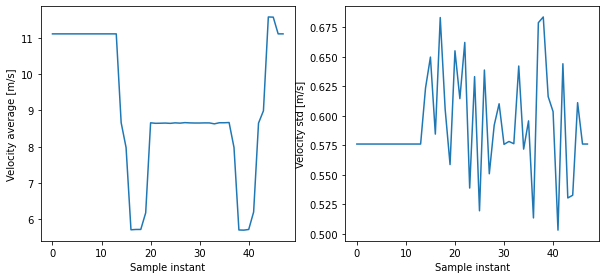

In [4]:
data = loadmat(mat_path)
mean_velocity, std_velocity = get_velocity_realizations(data, 25)
profile_fig = plot_profile(mean_velocity, std_velocity, 0)

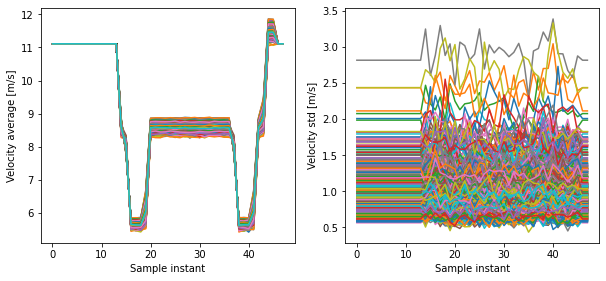

In [5]:
profiles_fig = plot_profiles(mean_velocity, std_velocity)

## Instance creation
### Network
- The depot is located to the right, 0.9 times the maximum radius to emulate an outer-city depot.
- There's a CS at the depot with normal technology (all cases)

Instance path:  ..\data\capacity_test\capacity_instance.xml


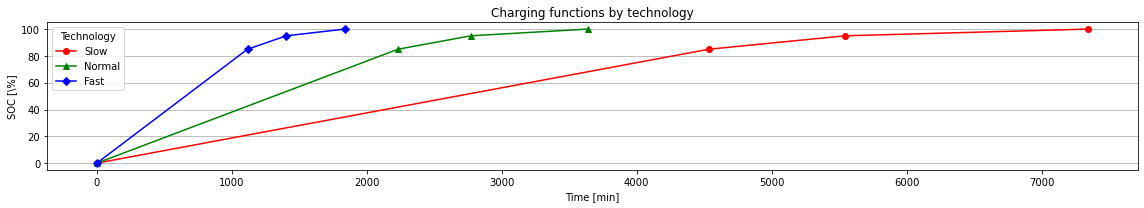

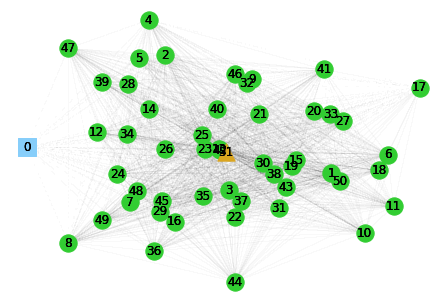

In [19]:
# Network parameters
main_folder = Path('../data/capacity_test/')
n_customers = 50
n_charg_sta = 1
min_radius, max_radius = 0, 20e3  # m
mintw_low, maxtw_low = 8 * 60 * 60, 13 * 60 * 60  # s
mintw_width, maxtw_width = 3 * 60 * 60, 5 * 60 * 60  # s
depot_loc = (-0.9*max_radius, 0.)

min_theta, max_theta = 0, 2 * np.pi
minreq, maxreq = 15, 80  # kg
mintime, maxtime = 60 * 5, 60 * 15  # s
std_factor = 1

tech1 = {0.0: 0.0, 75.6 * 60: 85.0, 92.4 * 60: 95.0, 122.4 * 60: 100.0}  # slow
tech2 = {0.0: 0.0, 37.2 * 60: 85.0, 46.2 * 60: 95.0, 60.6 * 60: 100.0}  # normal
tech3 = {0.0: 0.0, 18.6 * 60: 85.0, 23.4 * 60: 95.0, 30.6 * 60: 100.0}  # fast
tech_list = [tech1, tech2, tech3]
tech_price = [1., 1.5, 2.5]
tech_name = ["Slow", "Normal", "Fast"]
style_list = [('Slow', '-ro'), ('Normal', '-g^'), ('Fast', '-bD')]
which_technology = 1 # If None, choose random between tech_list
cs_at_depot = False
cs_capacity = 3

# Instance path
#instance_path = Path(main_folder, f'c{n_customers}_cs{n_charg_sta}_r{int(max_radius)}.xml')
instance_path = Path(main_folder, 'capacity_instance.xml')
print('Instance path: ', instance_path)

# Plot recharging functions
fig_recharging_functions = plot_recharging_functions(tech_list, style_list, 16, 9)

# Network
network = create_network(mean_velocity, std_velocity, n_customers, n_charg_sta, min_radius, max_radius, min_theta, max_theta, minreq, maxreq, 
                         mintime, maxtime, mintw_low, maxtw_low, mintw_width, maxtw_width, cs_capacity, std_factor, tech_list, tech_price, 
                         tech_name, cs_at_depot, which_technology, depot_loc)
fig_network = network.draw(save_to=None, width=0.003, edge_color='grey')

## Fleet

In [20]:
ev_id = 0
alpha_down, alpha_upp = 20, 95
battery_capacity = 24000*3600  # J
battery_capacity_nominal = battery_capacity
max_payload = 553 # kg
ev_weight = 1.52*1000  # kg
max_tour_duration = 6*60.*60 # s

PRB_time_window = 0.95
PRB_soc_policy = 0.95
PRB_max_tour_time = 0.95
WGH_time_window = 1e4
WGH_soc_policy = 1e4
WGH_max_tour_time = 1e4

ev = EV.GaussianElectricVehicle(0, ev_weight, battery_capacity, battery_capacity_nominal, alpha_upp, alpha_down, max_tour_duration, 
                                max_payload, 
                                PRB_time_window=PRB_time_window, 
                                PRB_soc_policy=PRB_soc_policy,
                                PRB_max_tour_time=PRB_max_tour_time, 
                                WGH_time_window=WGH_time_window, 
                                WGH_soc_policy=WGH_soc_policy,
                                WGH_max_tour_time=WGH_max_tour_time)
fleet = Fleet.GaussianFleet({0: ev})

fleet.set_network(network)
fleet.write_xml(instance_path, True)